# Music-Genre-Classifier RNN
Kaito Minami

In [1]:
!pip install PyWavelets

In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import StandardScaler
import audioread
from sklearn.preprocessing import StandardScaler
import pywt
# from pydub import AudioSegment


## 1. Data Processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the datasets
file_30_sec = '/content/drive/MyDrive/Colab Notebooks/GTZAN/features_30_sec.csv'
file_3_sec = '/content/drive/MyDrive/Colab Notebooks/GTZAN/features_3_sec.csv'

df_30_sec = pd.read_csv(file_30_sec)
df_3_sec = pd.read_csv(file_3_sec)

In [5]:
# Function to extract Mel spectrogram features
def extract_mel_spectrogram(file_path, sr=22050, n_mels=128):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models
    except (FileNotFoundError, librosa.util.exceptions.LibrosaError, audioread.NoBackendError):
        print(f"Audio file {file_path} not found or cannot be processed. Using CSV features instead.")
        mel_spectrogram_flattened = None
    return mel_spectrogram_flattened

# Splitting the dataset into training, validation, and test sets
def split_data(df, test_size=0.2, val_size=0.2):
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val['label'], random_state=42)
    return train, val, test

# Function to process the entire dataset and extract features
def process_dataset(df, audio_directory, feature_type='mel'):
    features = []
    labels = []
    for idx, row in df.iterrows():
        file_path = os.path.join(audio_directory, row['label'], row['filename'])
        if feature_type == 'mel':
            feature_vector = extract_mel_spectrogram(file_path)
        elif feature_type == 'wavelet':
            feature_vector = extract_wavelet_features(file_path)
        elif feature_type == 'chroma':
            feature_vector = extract_chroma_features(file_path)
        else:
            raise ValueError("Invalid feature type. Choose from 'mel', 'wavelet', 'chroma'.")

        # If audio features cannot be extracted, use CSV features
        if feature_vector is None:
            feature_vector = row.drop(['label']).filter(regex='^(?!filename)').values.astype(np.float32)
        features.append(feature_vector)
        labels.append(row['label'])

    # Ensure all feature vectors have the same length by padding or truncating
    max_length = max(len(f) for f in features)
    features = np.array([np.pad(f, (0, max_length - len(f)), 'constant') if len(f) < max_length else f[:max_length] for f in features])
    return features, np.array(labels)

In [6]:
    # Function to extract spectrograms and wavelet features\n",
    def extract_features(file_path, sr=22050, n_mels=128, wavelet='db1'):
        try:
            # Load audio file
            y, sr = librosa.load(file_path, sr=sr)
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models

            # Extract wavelet features
            coeffs = pywt.wavedec(y, wavelet, level=5)
            wavelet_features = np.concatenate([np.array(c).flatten() for c in coeffs])

            # Extract chroma features
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_features_flattened = chroma_stft.flatten()  # Flatten for use in ML models

            # Combine all features into a single feature vector
            combined_features = np.concatenate((mel_spectrogram_flattened, wavelet_features, chroma_features_flattened), axis=0)
        except (FileNotFoundError, librosa.util.exceptions.LibrosaError, audioread.NoBackendError):
            # If audio file is not found or cannot be loaded, use features from CSV instead
            print(f"Audio file {file_path} not found or cannot be processed. Using CSV features instead.")
            combined_features = None

        return combined_features

    def process_dataset2(df, audio_directory):
        features = []
        labels = []
        for idx, row in df.iterrows():
            file_path = os.path.join(audio_directory, row['label'], row['filename'])
            feature_vector = extract_features(file_path)
            # If audio features cannot be extracted, use CSV features
            if feature_vector is None:
                feature_vector = row.drop(['label']).filter(regex='^(?!filename)').values.astype(np.float32)
            features.append(feature_vector)
            labels.append(row['label'])
        # Ensure all feature vectors have the same length by padding or truncating
        max_length = max(len(f) for f in features)
        features = np.array([np.pad(f, (0, max_length - len(f)), 'constant') if len(f) < max_length else f[:max_length] for f in features])
        return features, np.array(labels)

In [7]:
# Standardizing dataset before splitting
scaler = StandardScaler()
df_30_sec_numeric = df_30_sec.select_dtypes(include=['float64', 'int64']).copy()
df_30_sec[df_30_sec_numeric.columns] = scaler.fit_transform(df_30_sec_numeric)

df_3_sec_numeric = df_3_sec.select_dtypes(include=['float64', 'int64']).copy()
df_3_sec[df_3_sec_numeric.columns] = scaler.fit_transform(df_3_sec_numeric)

# Splitting the dataset for 3-sec
train_df_3_sec, val_df_3_sec, test_df_3_sec = split_data(df_3_sec)

# Extract and process features for 3-sec dataset
audio_directory = '/content/drive/MyDrive/Colab Notebooks/GTZAN/genres_original'

# Features Extraction
train_features, train_labels = process_dataset2(train_df_3_sec, audio_directory)
val_features, val_labels = process_dataset2(val_df_3_sec, audio_directory)
test_features, test_labels = process_dataset2(test_df_3_sec, audio_directory)

Output hidden; open in https://colab.research.google.com to view.

## 2. LSTM model

In [8]:
def one_hot(genre_strings):
    genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

    y_one_hot = np.zeros((genre_strings.shape[0], len(genre_list)))
    for i, genre_string in enumerate(genre_strings):
        index = genre_list.index(genre_string)
        y_one_hot[i, index] = 1
    return y_one_hot

In [9]:
# adds timeseries sequence dimension to X and one-hot encode y
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], 1, train_features.shape[1])
train_labels = one_hot(train_labels)

val_features = val_features.reshape(val_features.shape[0], 1, val_features.shape[1])
val_labels = one_hot(val_labels)

test_features = test_features.reshape(test_features.shape[0], 1, test_features.shape[1])
test_labels = one_hot(test_labels)

(6393, 58)


In [10]:
# Model building
model = Sequential()
input_shape = (train_features.shape[1], train_features.shape[2])

model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape))
model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=10, activation="softmax"))

# Model compiling
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

# Model training
batch_size = 35  # num of training examples per minibatch
num_epochs = 100

print(train_features.shape, train_labels.shape)

history = model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_features, val_labels)
)

# Testing
score, accuracy = model.evaluate(
    test_features, test_labels, batch_size=batch_size, verbose=1
)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          95,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,682 (455.79 KB)

 Trainable params: 116,682 (455.79 KB)

 Non-trainable params: 0 (0.00 B)

(6393, 1, 58) (6393, 10)
Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3704 - loss: 2.0038 - val_accuracy: 0.5854 - val_loss: 1.2205
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6255 - loss: 1.1169 - val_accuracy: 0.6998 - val_loss: 0.8826
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7128 - loss: 0.8515 - val_accuracy: 0.7486 - val_loss: 0.7527
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7620 - loss: 0.7161 - val_accuracy: 0.7686 - val_loss: 0.6747
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7828 - loss: 0.6491 - val_accuracy: 0.7936 - val_loss: 0.6075
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8108 - loss: 0.5616 - val_accuracy: 0.8074 - val_loss: 0.5719
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8276 - loss: 0.5109 - val_accuracy: 0.8299 - val_loss: 0.5330
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8

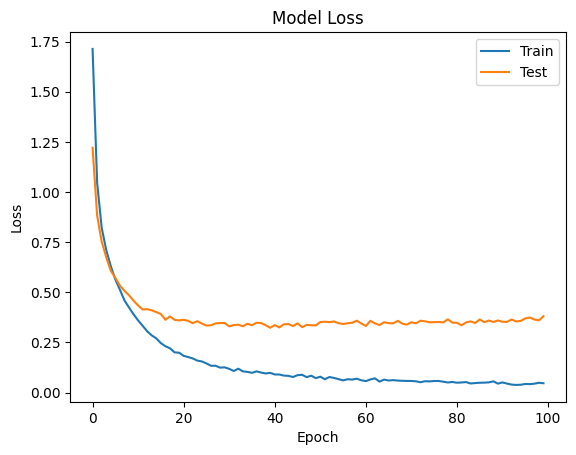

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

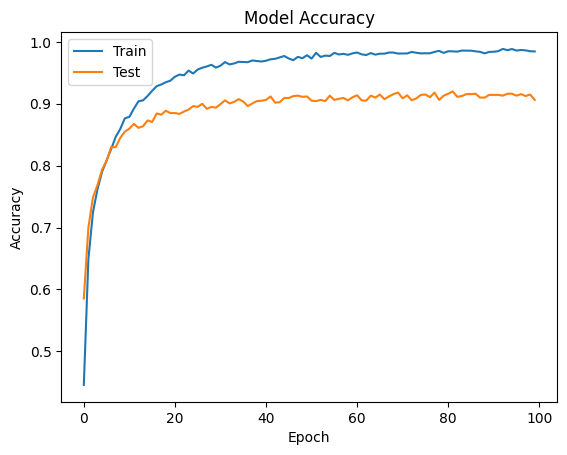

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [19]:
def plot_losses(hist):

  fig, axs = plt.subplots(1,2, figsize=(12, 4))
  axs[0].plot(hist.history['loss'])
  axs[0].plot(hist.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper right')

  axs[1].plot(hist.history['accuracy'])
  axs[1].plot(hist.history['val_accuracy'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper right')
  plt.show()

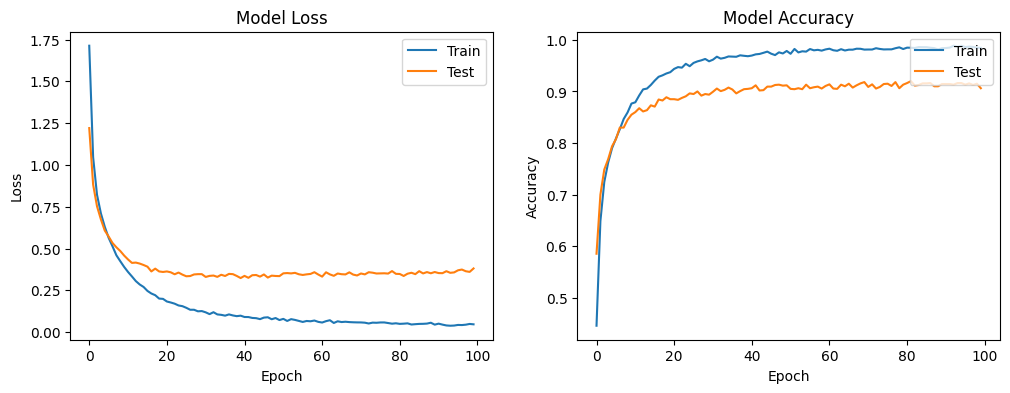

In [20]:
plot_losses(history)